# 2.6 概率

概率能够用于说明一个事件的确定程度。简单地说，机器学习就是根据概率来做出预测。

## 2.6.1 基本概率论

假设一个骰子是公平的，显然，在一次试验中，我们掷出某个点数的概率为$ \frac{1}{6} $。

那么，我们要如何验证一个骰子是公平的呢？

一种自然的方法是用事件（event）发生的频率作为其概率的估计值。

而大数定律（law of large numbers）恰好告诉我们：随着试验次数的增加，这个估计值会越来越接近潜在的真实概率。

下面我们用代码测试一下：

In [14]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

在统计学中，我们把从概率分布中抽取样本的过程称为抽样（sampling）。笼统地说，分布（distribution）是对事件的概率分配。其中，将概率分配给一些离散选择的分布称为多项分布（multinomial distribution）。

为了抽取一个样本，即掷骰子，我们只需输入一个概率向量。输出是另一个相同长度的向量：它在索引$ i $处的值是采样结果中$ i $出现的次数。

In [24]:
fair_probs = torch.ones(6) / 6
multinomial.Multinomial(1, fair_probs).sample()

tensor([0., 1., 0., 0., 0., 0.])

在估计一个骰子的公平性时，我们希望从同一分布中生成多个样本。

In [25]:
multinomial.Multinomial(100, fair_probs).sample() # 如果用for循环，速度会相当慢

tensor([15., 17., 12., 17., 19., 20.])

现在，我们知道如何抽样了，接下来模拟1000次投掷，并计算每个点数出现的频率，作为对真实概率的估计。

In [26]:
counts = multinomial.Multinomial(1000, fair_probs).sample()
counts / 1000

tensor([0.1590, 0.1690, 0.1550, 0.1640, 0.1720, 0.1810])

由于我们已知上面的抽样是公平的，因此每个结果的真实概率是$ \frac{1}{6} $，因此上面的估计值看起来不错。

我们也可以看到这些概率如何随着时间的推移收敛到真实概率。我们进行500组实验，每组抽10个样本。

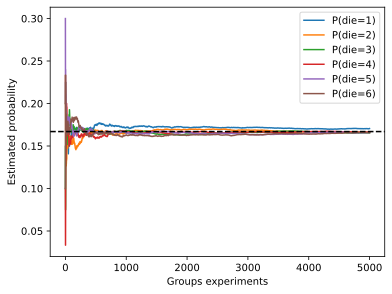

In [48]:
counts = multinomial.Multinomial(10, fair_probs).sample((5000,))
# print(counts, counts.shape)
cum_counts = counts.cumsum(dim=0)
# print(cum_counts)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
# print(estimates)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(), label=('P(die=' + str(i + 1) + ')'))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend()

每条实线对应了骰子的每个点数的出现频率，当试验次数不断增加时，可以看出曲线朝着真实概率收敛。

### 1. 概率论公理

一次试验可能出现的所有结果的集合称为样本空间（sample space）或结果空间（outcome space）。

事件（event）是一组给定样本空间的随机结果。

概率（probability）可以被认为是将集合映射到真实值的函数。在给定的样本空间$ S $中，事件$ A $发生的概率表示为$ P(A) $，并具有以下属性：

* $ P(A) \geq 0 $
* $ P(S) = 1 $
* 对于互斥（mutually exclusive）事件的任意一个可数序列$ A_1, A_2, \cdots $，有$ P(\bigcup^\infty_{i = 1}A_i) = \sum^\infty_{i = 1}P(A_i) $

### 2. 随机变量

随机变量（random variable）一般用$ X $表示，它几乎可以取任何数值。

随机变量分为离散（discrete）随机变量（如骰子点数）和连续（continuous）随机变量（如身高）。

我们用$ P(X) $表示随机变量$ X $的概率分布。例如，$ P({X = 5}) $可以表示$ X $取值为5的概率。

对于连续随机变量，我们将分布的度量从概率转变为概率密度（density）。

## 2.6.2 处理多个随机变量

很多时候，我们会处理多个随机变量。实际上，样本的每一个特征或标签都可以看作是一个随机变量。

### 1. 联合概率

联合概率（joint probability）反映了多个随机变量同时发生相应事件的概率，用$ P(X,Y) $表示。

### 2. 条件概率

条件概率（conditional probability）表示在已知某事件$ B $发生的前提下，另一个事件$ A $发生的概率，用$ P(A|B) $表示。

### 3. 贝叶斯定理

根据乘法法则，有$ P(AB) = P(A|B)P(B) = P(B|A)P(A)$

因此，有$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

这就是贝叶斯定理，反映了多个随机变量之间的关系。

### 4. 全概率公式

如果$ \bigcup^n_{i = 1}A_i = S $，且任意的$ A_i, A_j (i \neq j) $互斥，则对任一事件$ B $，有

$$ P(B) = \sum^n_{i = 1}P(BA_i) $$

### 5. 独立性

1. 直观描述：若A，B两个事件的发生互不相关，则称A与B相互独立。例如手机电量和使用者的年龄。
2. 数学定义：如果$ P(AB) = P(A)P(B) $，则事件A，B是相互独立的。

## 2.6.3 期望和方差

一个随机变量X的期望（expectation）或平均值（average）表示为

$$ E(X) = \sum_xxP(X = x) $$

当函数$ f(x) $的输入是从分布$ P $中抽取的随机变量时，$ f(x) $的期望为

$$ E[f(x)] = \sum_{x \sim P}f(x)P(X = x)$$

在许多情况下，我们希望衡量随机变量$ X $与其期望的偏差。这可以通过方差来量化：

$$ Var(X) = D(X) = E[(X - EX)^2] = E(X^2) - E^2(X) $$

方差的平方根称为标准差（standard deviation）。随机变量函数的方差衡量的是，当从该随机分布中抽取不同的x时，函数值偏离该函数的期望的程度：

$$ Var[f(x)] = E[(f(x) - E[f(x)])^2] $$